# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки:**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак:**
* `Price` — цена (евро)

## Подготовка данных

Импортируем необхдимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import time 

Выводим первые пять строк даннных.

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Создаем функцию для основынх статистических показатлей.

In [4]:
start = '\033[1m' # start и end для жирности текста
end = '\033[0m'

def info(data):
    
    category_type = list(df.select_dtypes(include=['category', object]).columns
                    )
    
    print(start + 'Посмотрим на общую информацию' + end)
    display(data.info())
    print('______________________________________________________________')
    print('')
    print(start + 'Посмотрим на основные статистические данные' + end)
    display(data.describe().T)
    print('______________________________________________________________')
    print('')
    print(start + 'Посмотрим, есть ли явные дубликаты' + end)
    display(data.duplicated().sum())
    print('______________________________________________________________')
    print('')
    print(start + 'Посмотрим на пропуски' + end)
    display(data.isna().sum())
    print('______________________________________________________________')
    print('')
    print(start + 'Посмотрим на неявные дубликаты' + end)
        
    for category in category_type:
        print(category, pd.Series(data[category].unique).str.lower().duplicated().sum())

Применяем функцию.

In [5]:
info(df)

Посмотрим на общую информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  ob

None

______________________________________________________________

Посмотрим на основные статистические данные


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


______________________________________________________________

Посмотрим, есть ли явные дубликаты


4

______________________________________________________________

Посмотрим на пропуски


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

______________________________________________________________

Посмотрим на неявные дубликаты
DateCrawled 0
VehicleType 0
Gearbox 0
Model 0
FuelType 0
Brand 0
NotRepaired 0
DateCreated 0
LastSeen 0


#### Вывод

Всего объектов в таблице - 354369. У пяти признаков пропущены значения. У признаков всего два тип данных. Пять признаков - `DateCrawled`, `LastSeen`, `PostalCode`, `NumberOfPictures`, `DateCreated` могут быть удалены, так как на прогноз они не повлияют. У признаков - `RegistrationYear`, `Power`, `RegistrationMonth` по статистическим данным "странные" данные, которые необходимо исправить. Также в данных имеются явные дубликаты. 

Предварительно можно сказать, что данных достаточно для исследования. Перед началом работы необходимо провести предобработку данных. 

### Предобработка данных

Удаляем явные дубликаты.

In [6]:
df = df.drop_duplicates()

Удаляем ненужные столбцы.

In [7]:
df = (df.drop(columns=['DateCrawled', 'LastSeen', 'PostalCode', 'NumberOfPictures'])
      )

Заполняем пропущенные значения данных.

In [8]:
df['Model'] = (df.groupby(['Brand'], dropna=False)['Model']
               .apply(lambda x: x.fillna(x.mode(dropna=False).values[0])))

df['Gearbox'] = (df.groupby(['Model'], dropna=False)['Gearbox']
               .apply(lambda x: x.fillna(x.mode(dropna=False).values[0])))

df['VehicleType'] = (df.groupby(['Model'], dropna=False)['VehicleType']
               .apply(lambda x: x.fillna(x.mode(dropna=False).values[0])))

df['FuelType'] = (df.groupby(['Model'], dropna=False)['FuelType']
               .apply(lambda x: x.fillna(x.mode(dropna=False).values[0])))

df['NotRepaired'] = df['NotRepaired'].fillna('no')

/opt/conda/lib/python3.9/site-packages/pandas/core/algorithms.py:944: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


Проверяем снова пропуски.

In [9]:
df.isna().sum()

Price                   0
VehicleType          1046
RegistrationYear        0
Gearbox                 0
Power                   0
Model                3374
Kilometer               0
RegistrationMonth       0
FuelType                0
Brand                   0
NotRepaired             0
DateCreated             0
dtype: int64

Проверяем пропущенные значения типа автокузова.

In [10]:
df.loc[df['VehicleType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
306,200,NaN,2009,manual,0,NaN,10000,0,petrol,sonstige_autos,no,2016-03-21 00:00:00
1345,899,NaN,1990,manual,37,NaN,60000,2,petrol,sonstige_autos,no,2016-03-21 00:00:00
1537,300,NaN,2010,manual,0,NaN,150000,12,petrol,sonstige_autos,no,2016-03-18 00:00:00
2065,0,NaN,2000,manual,0,NaN,5000,0,petrol,sonstige_autos,no,2016-03-07 00:00:00
2077,2250,NaN,2005,manual,0,NaN,150000,0,petrol,sonstige_autos,no,2016-03-16 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
353584,1,NaN,2000,manual,0,NaN,10000,0,petrol,sonstige_autos,no,2016-03-31 00:00:00
353961,200,NaN,1910,manual,0,NaN,5000,0,petrol,sonstige_autos,no,2016-03-17 00:00:00
354073,1750,NaN,1995,manual,0,NaN,100000,12,petrol,sonstige_autos,no,2016-03-19 00:00:00
354083,0,NaN,2000,manual,0,NaN,150000,0,petrol,sonstige_autos,no,2016-03-30 00:00:00


Удаляем строки с брэндом автомобиля с названием `sonstige_autos`.

In [11]:
df = df.drop(df[df['Brand']=='sonstige_autos'].index).reset_index(drop=True)

Снова проверяем пропуски.

In [12]:
df.isna().sum()

Price                0
VehicleType          5
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
dtype: int64

Снова проверяем пропущенные значения типа автокузова.

In [13]:
df.loc[df['VehicleType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
3305,199,NaN,1995,manual,0,samara,100000,0,petrol,lada,no,2016-04-05 00:00:00
26352,200,NaN,2016,manual,0,samara,150000,0,petrol,lada,no,2016-04-04 00:00:00
68684,99,NaN,1995,manual,0,samara,125000,0,petrol,lada,no,2016-03-18 00:00:00
74461,249,NaN,1985,manual,0,samara,125000,0,petrol,lada,no,2016-03-18 00:00:00
350189,2199,NaN,2016,manual,0,samara,70000,0,petrol,lada,no,2016-03-07 00:00:00


Нет смысла удалять строки с одним пропущенным признаком, поэтому заполним пропущенные данные.

In [14]:
df['VehicleType'] = (df.groupby(['Model'])['VehicleType']
               .apply(lambda x: x.fillna(x.mode().values[0])))

Проверяем пропущенные данные.

In [15]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
dtype: int64

Удалим пропущенное значение.

In [16]:
df = df.dropna()

Посмотрим на основные статистические данные.

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,350991.0,4410.822004,4503.363915,0.0,1099.0,2700.0,6399.0,20000.0
RegistrationYear,350991.0,2004.067070,79.123471,1000.0,1999.0,2003.0,2008.0,9999.0
Power,350991.0,110.267061,189.081382,0.0,69.0,105.0,142.0,20000.0
Kilometer,350991.0,128574.507608,37470.166343,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,350991.0,5.728247,3.721795,0.0,3.0,6.0,9.0,12.0


Значения признаков года регистрации авто, мощности и месяца регистрации необходимо исправить.

Строим границу для определения разумных границ регистарции автомобиля.

<AxesSubplot:>

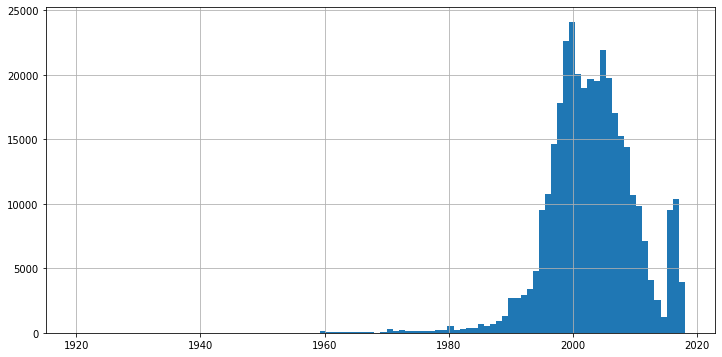

In [18]:
df['RegistrationYear'].hist(grid=True, bins=100, range=(1920, 2018), figsize=(12, 6))

Проверим самую последнюю дату создания анкеты.

In [19]:
df['DateCreated'].sort_values(ascending=False)

132736    2016-04-07 00:00:00
7858      2016-04-07 00:00:00
325264    2016-04-07 00:00:00
325272    2016-04-07 00:00:00
157743    2016-04-07 00:00:00
                 ...         
173408    2015-08-10 00:00:00
85770     2015-08-07 00:00:00
339016    2015-06-18 00:00:00
3964      2015-03-20 00:00:00
60613     2014-03-10 00:00:00
Name: DateCreated, Length: 350991, dtype: object

Приравняем год регистрации авто которые ниже и выше границы "разумных" к этим годам границы. В пределах нижней границы регистрации года начали появлятся большинство представленных брэндов, поэтому примем 1920 год, а верхнюю границу примем на основе последней даты создания анкеты.

In [20]:
df.loc[df['RegistrationYear'] < 1920, 'RegistrationYear'] = 1920
df.loc[df['RegistrationYear'] > 2016, 'RegistrationYear'] = 2016

Строим гистограмму для определения границ мощности автомобиля.

<AxesSubplot:>

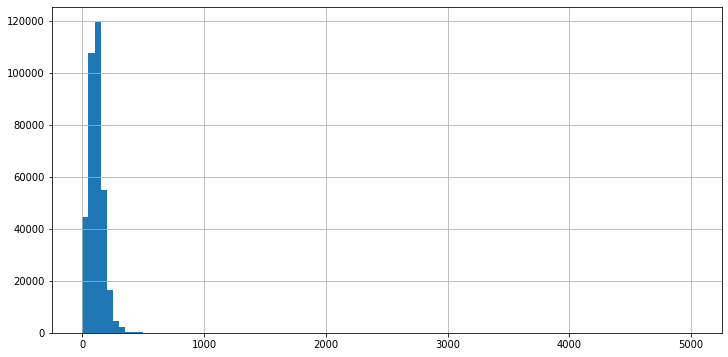

In [21]:
df['Power'].hist(grid=True, bins=100, range=(0, 5000), figsize=(12, 6))

Приравняем мощность авто которые ниже и выше границы "разумных" к этим мощностям. Минимальная граница принята на основе минимальной мощности с которым выпускались авто в зарождении мирового автопрома, а верхняя граница на основе максимальной мощности которые бывают у спорткаров. 

In [22]:
df.loc[df['Power'] < 10, 'Power'] = 10
df.loc[df['Power'] > 3000, 'Power'] = 3000

Приравняем месяц регистрации со значением 0 к 1.

In [23]:
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

Проверим основные статистические данные.

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,350991.0,4410.822004,4503.363915,0.0,1099.0,2700.0,6399.0,20000.0
RegistrationYear,350991.0,2003.111100,7.256093,1920.0,1999.0,2003.0,2008.0,2016.0
Power,350991.0,109.554886,85.876142,10.0,69.0,105.0,142.0,3000.0
Kilometer,350991.0,128574.507608,37470.166343,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,350991.0,5.832033,3.571518,1.0,3.0,6.0,9.0,12.0


df.loc[df['Power'] < 10, 'Power']  = 10   df.loc[df['

In [25]:
df.loc[df['Price'] < 450, 'Price'] = 450

Удалим признак, который нам не понадобится.

In [26]:
df = df.drop(columns=['DateCreated']) 

Посмотрим на корреляцию.

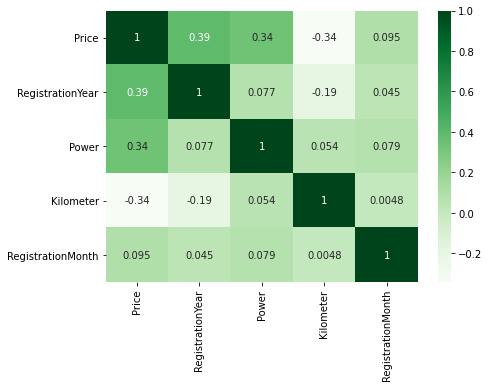

In [27]:
corr = df.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap="Greens", annot=True)
plt.show()

Максимальная коррелирует с ценой мощность и километраж. Меньше всего корреляцию с ценой у признаков год регистрации авто и месяц регистрации авто. Нецелевые признаки между собой слабо коррелируют, что является хорошим признаком для дальнейшего обучения и прогноза.

#### Вывод

При предобработке были удалены явные дубликаты, удалены пропущенные значения, заполнены пропущенные значения и удалены ненужные признаки. При проверке корреляции признаков с целевым признаком, выявили признаки - `Power`, `Kilometr`, которые больше всего имеют значения корреляции. Километраж имеют при этом отрицательную корреляцию.

## Обучение моделей

Разделим данные на обучающую и тестовую в соотношении 4:1.

In [30]:
# разделим исходые данные на обучающую и тестовую
df_train, df_test = train_test_split(df, test_size=0.25, random_state=123)

In [31]:
# обучающие переменные
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']
# тестовые переменные
features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

Преобразуем категориальные признаки в численные.

In [32]:
df_forest = df.copy()
# преобразуем категориальные признаки в численные
cat_feat = list(df_forest.select_dtypes(include='object').columns)
label_encode = LabelEncoder()
for column in cat_feat:
    label_encode.fit(df_forest[column].astype('str'))
    df_forest[column] = label_encode.transform(df_forest[column].astype('str'))

# Разделим данные на обучающую и тестовую
df_train_forest, df_test_forest = train_test_split(df_forest, test_size=0.25, random_state=123)

# обучающие переменные
features_train_forest = df_train_forest.drop(['Price'], axis=1)
target_train_forest = df_train_forest['Price']
# тестовые переменные
features_test_forest = df_test_forest.drop(['Price'], axis=1)
target_test_forest = df_test_forest['Price']

Посмотрим на данные после кодирования.

In [33]:
features_train_forest.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
148147,5,2004,1,116,80,150000,5,6,21,0
249023,7,2010,0,170,59,150000,5,2,20,0
153754,4,2016,1,136,10,150000,5,6,25,0
172333,1,2002,1,231,11,150000,2,6,2,0
322653,4,1997,1,103,53,150000,1,6,9,0


Проверяем размеры разделенных данных.

In [34]:
pd.Series([features_train.shape,  target_train.shape, features_test.shape, target_test.shape])

0    (263243, 10)
1       (263243,)
2     (87748, 10)
3        (87748,)
dtype: object

Приведем численные признаки к одному масштабу.

In [35]:
pd.options.mode.chained_assignment = None # чтобы не было ошибки работы

numeric = ['RegistrationYear', 'RegistrationMonth', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

# применим масштабирование к разделенным данным для модели кэтбуста 
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# применим масштабирование к разделенным данным для модел RandomForest и LightGBM
features_train_forest[numeric] = scaler.transform(features_train_forest[numeric])
features_test_forest[numeric] = scaler.transform(features_test_forest[numeric])

Посмотрим на данные после масштабирования признаков.

In [36]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
148147,small,0.123109,manual,0.077938,cooper,0.571062,-0.234298,petrol,mini,no
249023,wagon,0.951548,auto,0.717640,c_klasse,0.571062,-0.234298,gasoline,mercedes_benz,no
153754,sedan,1.779987,manual,0.314865,3_reihe,0.571062,-0.234298,petrol,peugeot,no
172333,convertible,-0.153037,manual,1.440267,3er,0.571062,-1.074197,petrol,bmw,no
322653,sedan,-0.843403,manual,-0.076065,bravo,0.571062,-1.354164,petrol,fiat,no


**Обучим модель CatBoost**

С помощью гридсёрч опредлеим лучшие параметры.

In [37]:
cat_feat = list(df.select_dtypes(include='object').columns)

cat_model = CatBoostRegressor(random_state=123)

search_space = {
    "depth" : [8, 12],
    "learning_rate" : [0.1, 0.3]
}

grid_cat = GridSearchCV(cat_model, search_space, scoring='neg_root_mean_squared_error', cv = 3)

grid_cat.fit(features_train, target_train, cat_features=cat_feat)

print(grid_cat.best_params_)

0:	learn: 4178.3355647	total: 350ms	remaining: 5m 49s
1:	learn: 3916.1229857	total: 601ms	remaining: 5m
2:	learn: 3683.0968216	total: 912ms	remaining: 5m 3s
3:	learn: 3483.8923621	total: 1.19s	remaining: 4m 55s
4:	learn: 3307.8667072	total: 1.41s	remaining: 4m 40s
5:	learn: 3151.5355930	total: 1.63s	remaining: 4m 29s
6:	learn: 3009.8496994	total: 1.88s	remaining: 4m 26s
7:	learn: 2890.3562216	total: 2.17s	remaining: 4m 29s
8:	learn: 2781.5887517	total: 2.51s	remaining: 4m 36s
9:	learn: 2687.8536027	total: 2.74s	remaining: 4m 31s
10:	learn: 2598.8756608	total: 2.96s	remaining: 4m 26s
11:	learn: 2530.5149860	total: 3.19s	remaining: 4m 23s
12:	learn: 2468.2648868	total: 3.43s	remaining: 4m 20s
13:	learn: 2411.5015221	total: 3.68s	remaining: 4m 19s
14:	learn: 2363.9586171	total: 3.89s	remaining: 4m 15s
15:	learn: 2321.1276861	total: 4.07s	remaining: 4m 10s
16:	learn: 2279.5649755	total: 4.27s	remaining: 4m 7s
17:	learn: 2245.3234737	total: 4.49s	remaining: 4m 4s
18:	learn: 2213.2342791	tot

In [38]:
%%time 

cat_model = CatBoostRegressor(**grid_cat.best_params_)
cat_model.fit(features_train, target_train, cat_features=cat_feat)

0:	learn: 4154.3511077	total: 622ms	remaining: 10m 21s
1:	learn: 3869.4811750	total: 1.38s	remaining: 11m 27s
2:	learn: 3620.5078501	total: 2.04s	remaining: 11m 19s
3:	learn: 3399.9538227	total: 2.69s	remaining: 11m 10s
4:	learn: 3204.1930616	total: 3.3s	remaining: 10m 56s
5:	learn: 3036.7972321	total: 3.8s	remaining: 10m 29s
6:	learn: 2885.6122149	total: 4.47s	remaining: 10m 33s
7:	learn: 2754.6353270	total: 4.97s	remaining: 10m 16s
8:	learn: 2644.4583081	total: 5.5s	remaining: 10m 5s
9:	learn: 2544.2296766	total: 6.1s	remaining: 10m 3s
10:	learn: 2456.3603637	total: 6.85s	remaining: 10m 15s
11:	learn: 2379.3528994	total: 7.46s	remaining: 10m 14s
12:	learn: 2308.7435308	total: 8.04s	remaining: 10m 10s
13:	learn: 2248.0172587	total: 8.54s	remaining: 10m 1s
14:	learn: 2193.9525133	total: 9.05s	remaining: 9m 54s
15:	learn: 2150.0510694	total: 9.75s	remaining: 9m 59s
16:	learn: 2111.1501862	total: 10.4s	remaining: 10m 2s
17:	learn: 2076.8271461	total: 11s	remaining: 10m
18:	learn: 2048.43

Измерим знаечение RMSE.

In [39]:
%%time
cat_pred_test = cat_model.predict(features_test)
print(f'RMSE тестовой выборки: {mean_squared_error(target_test, cat_pred_test)**0.5}')

RMSE тестовой выборки: 1660.4332751697077
CPU times: user 1.76 s, sys: 12 ms, total: 1.77 s
Wall time: 1.77 s


**Обучим модель RandomForest**

In [40]:
rfr = RandomForestRegressor(random_state=123)

params = {'n_estimators' : [100, 150],
          'max_depth' : [6, 12]
         }

grid_rfr = GridSearchCV(rfr, params, scoring='neg_root_mean_squared_error', cv = 3)

grid_rfr.fit(features_train_forest, target_train_forest)

print(grid_rfr.best_params_)

{'max_depth': 12, 'n_estimators': 150}


In [43]:
%%time 
forest_model = RandomForestRegressor(**grid_rfr.best_params_)
forest_model.fit(features_train_forest, target_train_forest)

CPU times: user 1min 2s, sys: 204 ms, total: 1min 2s
Wall time: 1min 2s


RandomForestRegressor(max_depth=12, n_estimators=150)

Измерим знаечение RMSE.

In [44]:
%%time
forest_pred_test = forest_model.predict(features_test_forest)
print(f'RMSE тестовой выборки: {mean_squared_error(target_test_forest, forest_pred_test)**0.5}')

RMSE тестовой выборки: 1872.9862219935687
CPU times: user 1.36 s, sys: 37 µs, total: 1.36 s
Wall time: 1.37 s


**Обучим модель LightGBM**

In [45]:
light_model = lgb.LGBMRegressor(random_state=12345)

search_space = {
    "max_depth" : [8, 12],
    "learning_rate" : [0.1, 0.3]
}

grid_light = GridSearchCV(light_model, search_space, scoring='neg_root_mean_squared_error', cv = 3)

grid_light.fit(features_train_forest, target_train_forest)

print(grid_light.best_params_)

{'learning_rate': 0.3, 'max_depth': 12}


In [47]:
%%time 
light_model = lgb.LGBMRegressor(**grid_light.best_params_)
light_model.fit(features_train_forest, target_train_forest)

CPU times: user 37.7 s, sys: 218 ms, total: 37.9 s
Wall time: 38.4 s


LGBMRegressor(learning_rate=0.3, max_depth=12)

Измерим знаечение RMSE.

In [48]:
%%time 
light_pred_test = light_model.predict(features_test_forest)
print(f'RMSE тестовой выборки: {mean_squared_error(target_test_forest, light_pred_test)**0.5}')

RMSE тестовой выборки: 1765.0407188856898
CPU times: user 476 ms, sys: 7.45 ms, total: 484 ms
Wall time: 500 ms


## Анализ моделей

Цель задачи - построить модель для определения стоимости автомобиля с метрикой **RMSE** до 2500, была достигнута.

Картина распределения "мест" моделей по метрике **RMSE** не сильно разнится. Самое низкое значение метрики у **CatBoost**. На втором месте — **LightGBM**. Самое низкое качество предсказания у **RandomForest**. Если говорить про лучшую модель, а именно **CatBoost**, то для него такие относительно высокие значения получились при глубине дерева - 12, и скорости обучения - 0.1.

Высокая скорость работы у **CatBoost**. Скорость **RandomForest** тоже высокая. **LightGBM** медленнее всех/

Сравнение значений качества метрик приведено к общей таблице(см.выше).

In [50]:
pd.DataFrame({'RMSE': [1660, 1873, 1765]
              , 'Скорость обучения (сек)': [611, 62, 38]
             , 'Скорость предсказания (сек)': [1.77, 1.37, 0.5]}
             , index=['CatBoost', 'RandomForest', 'LightGBM'])

,RMSE,Скорость обучения (сек),Скорость предсказания (сек)
CatBoost,1660,611,1.77
RandomForest,1873,62,1.37
LightGBM,1765,38,0.50
